In [1]:
#IMPORT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
#LOAD DATA

# Merge disbursement and repayment tables
file = 'C:/Users/Brandy Odhiambo/Desktop/Credable/case_study.xlsx'

disbursements = pd.read_excel(file,sheet_name='Disbursements')
repayments = pd.read_excel(file,sheet_name='Repayments')

# Merge on customer_id
merged_data = pd.merge(disbursements, repayments, how='left', on='customer_id')
print(merged_data.head())


                                         customer_id  disb_date   tenure  \
0  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   
1  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   
2  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   
3  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   
4  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   

                        account_num  loan_amount  loan_fee  \
0  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2   
1  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2   
2  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2   
3  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2   
4  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2   

                         date_time  amount  rep_month repayment_type  
0  11-JUN-24 11.24.49.000000000 AM   38.89   202406.0      Automatic  
1  11-JUN-24 11.30.54.000000

In [3]:
#FORMATTING AND DEFAULTED LOANS

# Ensure date columns are in datetime format
merged_data['disb_date'] = pd.to_datetime( merged_data['disb_date'], 
    format='%d-%b-%y %I.%M.%S.%f %p')
merged_data['date_time'] = pd.to_datetime( merged_data['date_time'], 
    format='%d-%b-%y %I.%M.%S.%f %p')

# Calculate expected repayment date
merged_data['expected_repayment_date'] = merged_data['disb_date'] + pd.to_timedelta(merged_data['tenure'])

# Identify defaulted loans
merged_data['is_default'] = (merged_data['date_time'] > merged_data['expected_repayment_date']) | (merged_data['date_time'].isna())

# Preview the data
print(merged_data[['customer_id', 'loan_amount', 'disb_date', 'date_time', 'expected_repayment_date', 'is_default']])



                                              customer_id  loan_amount  \
0       91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...          360   
1       91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...          360   
2       91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...          360   
3       91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...          360   
4       91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...          360   
...                                                   ...          ...   
770246  9b670d737454e84b0aa914ed34cae89c020fc817c09f7e...          440   
770247  9b670d737454e84b0aa914ed34cae89c020fc817c09f7e...          440   
770248  9b670d737454e84b0aa914ed34cae89c020fc817c09f7e...          440   
770249  9b670d737454e84b0aa914ed34cae89c020fc817c09f7e...          440   
770250  9b670d737454e84b0aa914ed34cae89c020fc817c09f7e...          440   

        disb_date           date_time expected_repayment_date  is_default  
0      2024-03-19 2024-06-11 11:24:

In [4]:
#AGGREGATIONS

# Convert disbursement_date to monthly periods for grouping
merged_data['disbursement_month'] = merged_data['disb_date'].dt.to_period('M')

# Aggregate defaulted loans
defaulted_loans = merged_data[merged_data['is_default']].groupby('disbursement_month').agg({
    'loan_amount': 'sum',  # Total amount of defaulted loans
    'customer_id': 'count'  # Number of defaulted loans
}).reset_index()

# Rename columns 
defaulted_loans.rename(columns={'customer_id': 'number_of_defaults', 'loan_amount': 'total_defaulted_amount'}, inplace=True)

# Preview the aggregated data
print(defaulted_loans)



  disbursement_month  total_defaulted_amount  number_of_defaults
0            2024-01                84550815               91180
1            2024-02                78229769               81956
2            2024-03                76484165               75518
3            2024-04                60512251               56743
4            2024-05                45536933               42324
5            2024-06                23730126               23202
6            2024-07                12302749               11667
7            2024-08                 1664966                1859


In [7]:
#CALCULATE DEFAULT RATE

# Merge default data with disbursements data
monthly_data = merged_data.groupby('disbursement_month').agg({
    'loan_amount': 'sum',  # Total disbursed
    'amount': 'sum'  # Total repaid
}).reset_index()

# Add default rates to monthly data
monthly_data['default_rate'] = (defaulted_loans['total_defaulted_amount'] / monthly_data['loan_amount']) * 100

# Preview data with default rates
print(monthly_data[['disbursement_month', 'loan_amount', 'amount', 'default_rate', ]])


  disbursement_month  loan_amount       amount  default_rate
0            2024-01     97159350  52250407.34     87.022829
1            2024-02    106590269  50758795.81     73.392975
2            2024-03    124681985  52201203.21     61.343397
3            2024-04    126630360  49367557.05     47.786527
4            2024-05    129272689  50263696.98     35.225486
5            2024-06    113148700  43164055.33     20.972513
6            2024-07    111162062  43148026.20     11.067399
7            2024-08     36538572  14520726.67      4.556735


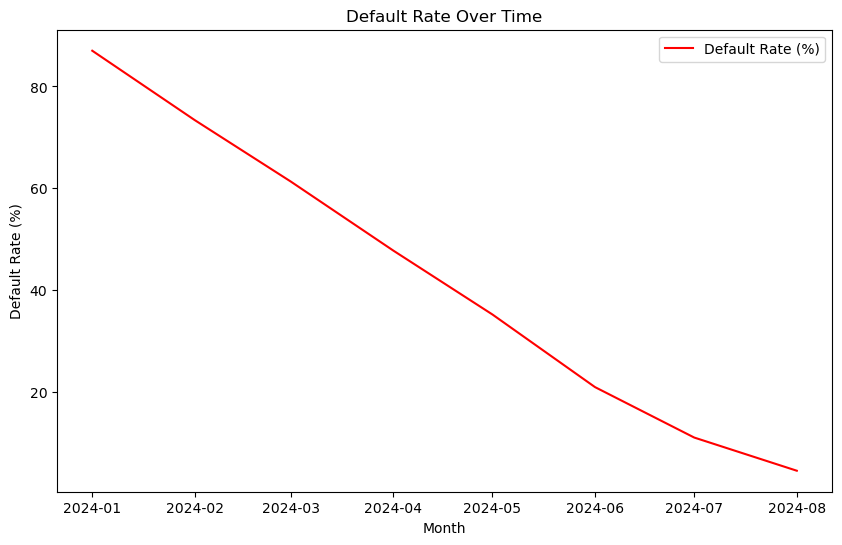

In [24]:
#VISUALIZE DEFAULT RATES

plt.figure(figsize=(10, 6))
plt.plot(monthly_data['disbursement_month'].dt.to_timestamp(), monthly_data['default_rate'], label='Default Rate (%)', color='red')
plt.xlabel('Month')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate Over Time')
plt.legend()
plt.show()


In [27]:
#FORECAST
#Derive profit/loss for each month
monthly_data['profit_loss'] = monthly_data['amount'] - monthly_data['loan_amount']


In [28]:
#Set month as index in chronological order
monthly_data['month'] = pd.to_datetime(monthly_data['month'])  # Convert 'month' to datetime
monthly_data.set_index('month', inplace=True)  # Set 'month' as the index
monthly_data['profit_loss'] = monthly_data['amount'] - monthly_data['loan_amount']

KeyError: 'month'

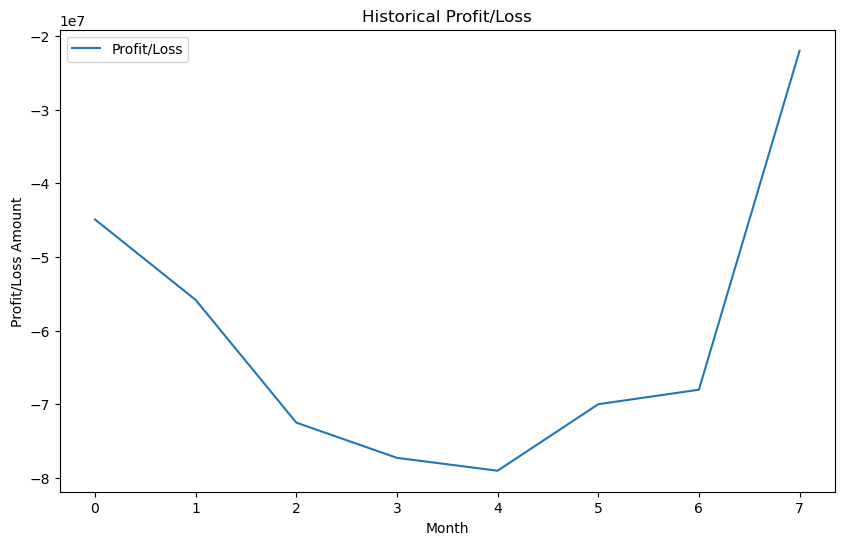

In [29]:
#Visualize Historical Data

plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['profit_loss'], label='Profit/Loss')
plt.xlabel('Month')
plt.ylabel('Profit/Loss Amount')
plt.title('Historical Profit/Loss')
plt.legend()
plt.show()


In [ ]:
#FORECASTING USING STATS MODELS AND SARIMAX

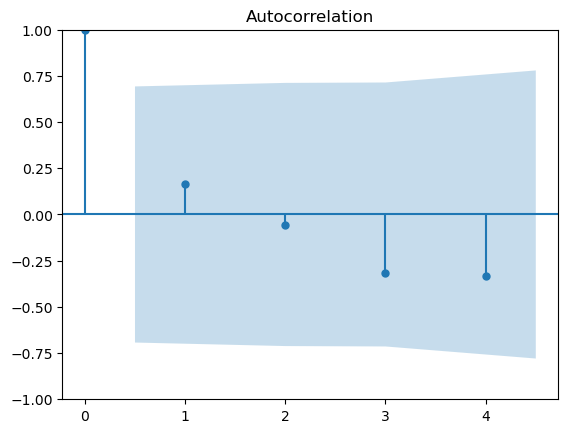

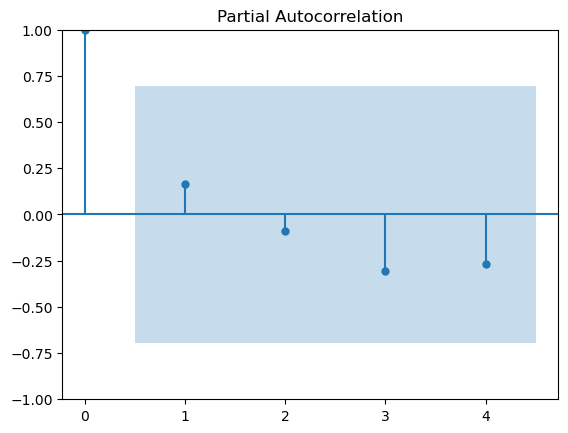

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Set model Parameters

# Plot ACF and PACF
plot_acf(monthly_data['profit_loss'])
plot_pacf(monthly_data['profit_loss'])
plt.show()


In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set SARIMA parameters (you can adjust these based on ACF/PACF or trial and error)
model = SARIMAX(monthly_data['profit_loss'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit()

# Print model summary
print(sarima_model.summary())


C:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Anaconda\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
C:\Anaconda\Lib\site-packages\statsmodels\tools\eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: 

                                     SARIMAX Results                                      
Dep. Variable:                        profit_loss   No. Observations:                    8
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Sun, 23 Mar 2025   AIC                             10.000
Time:                                    21:23:21   BIC                                nan
Sample:                                         0   HQIC                               nan
                                              - 8                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

C:\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8    -22017845.33
9    -22017845.33
10   -22017845.33
Name: predicted_mean, dtype: float64


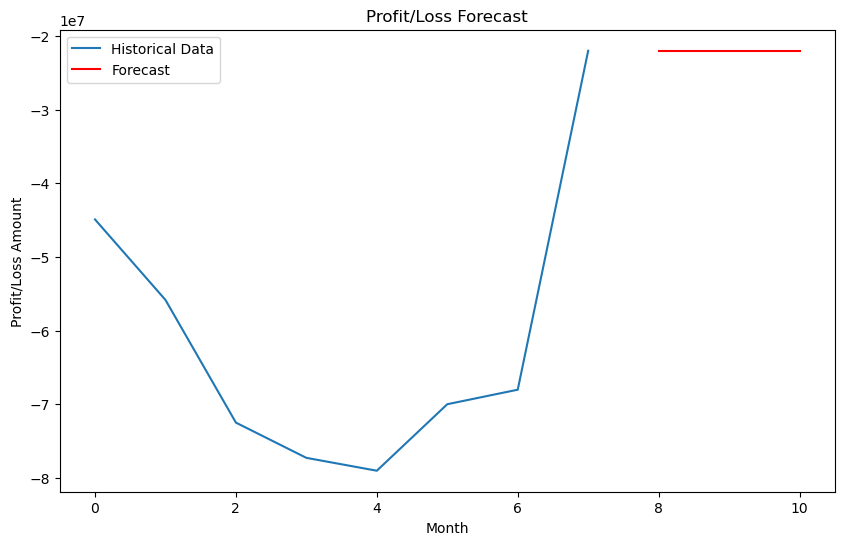

In [32]:
# Forecast for the next 3 months
forecast = sarima_model.get_forecast(steps=3)

# Get confidence intervals for the forecast
forecast_ci = forecast.conf_int()

# Print forecasted values
print(forecast.predicted_mean)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['profit_loss'], label='Historical Data')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Profit/Loss Amount')
plt.title('Profit/Loss Forecast')
plt.legend()
plt.show()


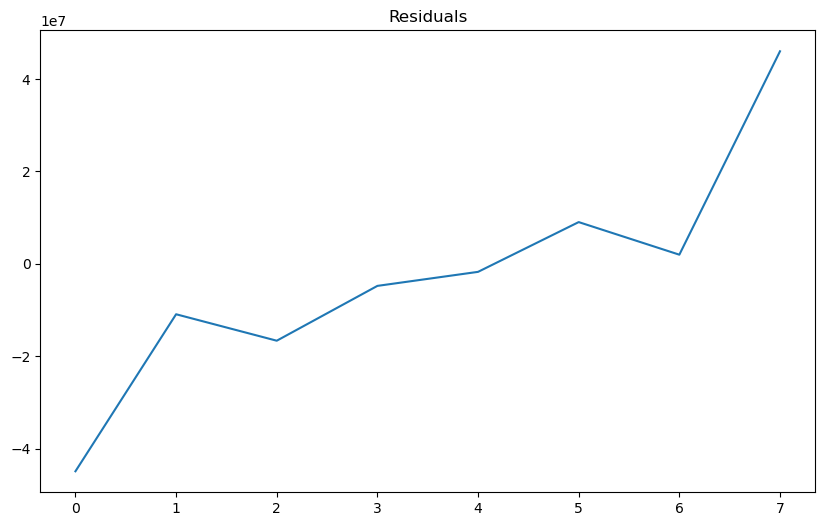

In [33]:
#Evaluate Model using residuals
residuals = sarima_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()
